In [2]:
import rasterio
import numpy as np
import matplotlib as mpl
import subprocess
from matplotlib import pyplot
import geopandas as gpd
import os, math
from matplotlib import pyplot as plt

In [3]:
vn_reservoirs_path = 'VN_Reservoirs.shp'
df = gpd.read_file(vn_reservoirs_path)
plt.rcParams['figure.figsize'] = 5, 5
ho_tri_an = df[df.AREA_SKM == 277.4]

## Find Rectangle that can bound!

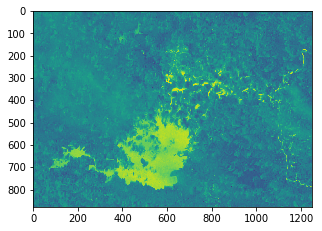

In [4]:
geotiffPath = 'L7_Data/2010_06_20/'
NDWI = rasterio.open(geotiffPath + 'NDWI3.TIF')
from utils.landsatHepers import *
ndwi, original_transform = getMaskFromShape(ho_tri_an, NDWI, eps=2000)
pyplot.imshow(ndwi)

## Segmentation based on BFS

Area = 83.0799


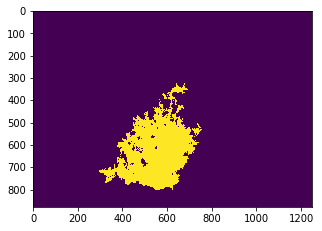

In [5]:
area, segment_array = countPixel(ndwi, 'NDWI3', [600, 600])
print("Area = {0}".format(area * 900 / 1000000))
pyplot.imshow(segment_array)

Normalize Segmented file

In [5]:
segment_array = normalizePixelOnBoundaries(segment_array)

## Find Boundaries of Image

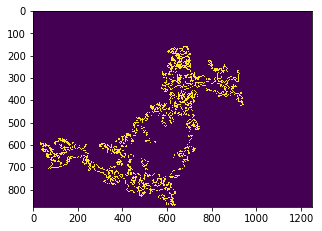

In [6]:
boundaries_array = findBoundariesFromSegmentedArray(segment_array)
plt.imshow(boundaries_array)

Depends all boundaries found, choose the most similar to original.

In [7]:
__shape = getMostSimilarShape(boundaries_array, original_transform, ho_tri_an)

## Try to convert to original coordinates and Masking

In [9]:
new_shape_in_original_coordinates = [transform_geom(NDWI.crs, df.crs, mapping(__shape))]
_new_shape = shape(new_shape_in_original_coordinates[0])
_new_geom = mapping(_new_shape)
_new_shape = [transform_geom(ho_tri_an.crs, NDWI.crs, _new_geom)]

In [11]:
from shapely.wkt import dump as DumpPolygon, load as LoadPolygon

new_shape = LoadPolygon(open(geotiffPath + 'shape.wkt'))
new_geom = mapping(new_shape)
new_shape = [transform_geom(ho_tri_an.crs, NDWI.crs, new_geom)]

In [13]:
ho_tri_an_shape = ho_tri_an.geometry.values[0]
ho_tri_an_geom = mapping(ho_tri_an_shape)
ho_tri_an_shape = [transform_geom(ho_tri_an.crs, NDWI.crs,ho_tri_an_geom)]